# SMS Spam classification with Naive Bayes Classifier.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
import warnings
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import joblib

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data = data[['v1', 'v2']]  # Select only the necessary columns
data.columns = ['label', 'text']  # Rename columns for better readability
data.head(10)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
# Data Cleaning Function
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]
    return ' '.join(text)

In [6]:
# Applying text cleaning
data['text'] = data['text'].apply(clean_text)
data.head(10)

,label,text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts st ...
3,ham,u dun say early hor u c already say
4,ham,nah think go usf life around though
5,spam,freemsg hey darling week word back like fun st...
6,ham,even brother like speak treat like aid patent
7,ham,per request melle melle oru minnaminunginte nu...
8,spam,winner valued network customer selected receiv...
9,spam,mobile month u r entitled update latest colour...


 ## Data Visualization
Visualizing class distribution using Bar Plot and Pie Chart

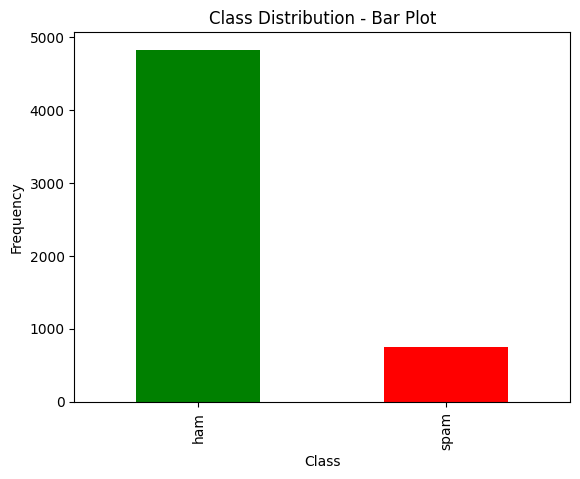

In [7]:
# Visualizing class distribution
count_class = data['label'].value_counts()

# Bar plot
count_class.plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution - Bar Plot')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

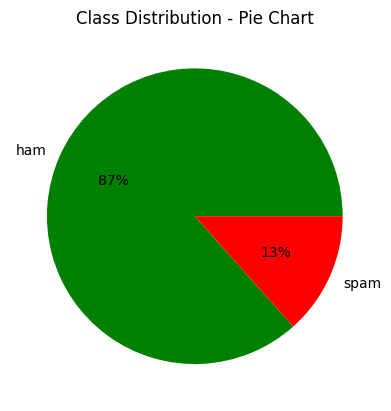

In [8]:
# Pie chart
count_class.plot(kind='pie', autopct='%1.0f%%', colors=['green', 'red'])
plt.title('Class Distribution - Pie Chart')
plt.ylabel('')
plt.show()


## Frequent Words Analysis

Analyze the most frequent words in spam and non-spam messages

In [9]:
ham_words = Counter(" ".join(data[data['label'] == 'ham']['text']).split()).most_common(20)
df_ham = pd.DataFrame(ham_words, columns=['Word', 'Count'])
df_ham

,Word,Count
0,u,1084
1,get,320
2,gt,318
3,lt,316
4,ok,287
5,go,279
6,call,251
7,day,247
8,know,245
9,come,245


In [10]:
spam_words = Counter(" ".join(data[data['label'] == 'spam']['text']).split()).most_common(20)
df_spam = pd.DataFrame(spam_words, columns=['Word', 'Count'])
df_spam

,Word,Count
0,call,371
1,å,300
2,free,226
3,u,191
4,txt,170
5,p,159
6,text,145
7,ur,144
8,mobile,140
9,stop,124


## Plotting Frequent Words
Plot the most frequent words in both ham and spam messages.

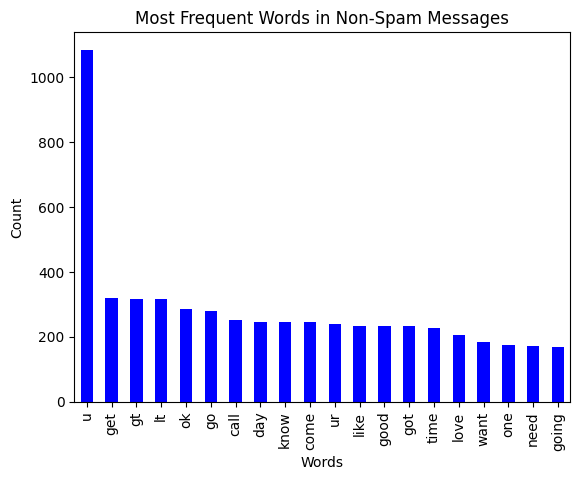

In [11]:
# Plotting the most frequent words in non-spam messages
df_ham.plot.bar(x='Word', y='Count', legend=False, color='blue')
plt.title('Most Frequent Words in Non-Spam Messages')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()

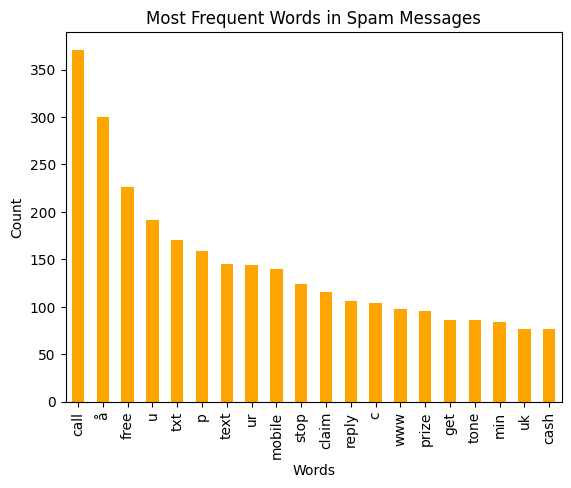

In [12]:
# Plotting the most frequent words in spam messages
df_spam.plot.bar(x='Word', y='Count', legend=False, color='orange')
plt.title('Most Frequent Words in Spam Messages')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()

## Feature Extraction and Splitting the Data
Convert the text data into numerical features using TF-IDF and split the data into training and testing sets.

In [13]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['text'])

TF-IDF: Transforms the text data into TF-IDF features.

In [14]:

# Encoding labels
data['label'] = data['label'].map({'spam': 1, 'ham': 0})

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.33, random_state=42)
print(f'Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}')


Training set shape: (3733, 6961), Testing set shape: (1839, 6961)


## Step 6: Model Training and Evaluation
Train a Multinomial Naive Bayes model and evaluate its performance.

In [15]:
# Hyperparameter tuning for Multinomial Naive Bayes
alphas = np.arange(1/100000, 20, 0.11)
train_scores, test_scores = [], []
recall_scores, precision_scores = [], []

In [16]:
# Training and evaluating the model for each alpha value
for alpha in alphas:
    nb_model = MultinomialNB(alpha=alpha)
    nb_model.fit(X_train, y_train)
    train_scores.append(nb_model.score(X_train, y_train))
    test_scores.append(nb_model.score(X_test, y_test))
    recall_scores.append(metrics.recall_score(y_test, nb_model.predict(X_test)))
    precision_scores.append(metrics.precision_score(y_test, nb_model.predict(X_test)))

In [17]:
# Create a DataFrame to store the results
results = pd.DataFrame({
    'Alpha': alphas,
    'Train Score': train_scores,
    'Test Score': test_scores,
    'Recall': recall_scores,
    'Precision': precision_scores
})
results.head(10)

,Alpha,Train Score,Test Score,Recall,Precision
0,0.00001,0.998393,0.966830,0.880952,0.877470
1,0.11001,0.996518,0.977162,0.908730,0.923387
2,0.22001,0.994642,0.975530,0.884921,0.933054
3,0.33001,0.993035,0.976074,0.865079,0.956140
4,0.44001,0.991160,0.975530,0.849206,0.968326
5,0.55001,0.988213,0.970092,0.801587,0.975845
6,0.66001,0.986338,0.970092,0.789683,0.990050
7,0.77001,0.980980,0.965742,0.757937,0.989637
8,0.88001,0.978570,0.963023,0.734127,0.994624
9,0.99001,0.976694,0.961936,0.726190,0.994565


## Model Selection
Select the best model based on precision and accuracy.

In [18]:
# Selecting the best model based on Precision and Accuracy
best_index = results['Precision'].idxmax()
best_result = results.iloc[best_index]
best_alpha = best_result['Alpha']

In [19]:
# Train the best model
best_model = MultinomialNB(alpha=best_alpha)
best_model.fit(X_train, y_train)

# Display the best model's results
best_result

Alpha          1.100010
Train Score    0.974016
Test Score     0.957586
Recall         0.690476
Precision      1.000000
Name: 10, dtype: float64

##  Plotting Confusion Matrix

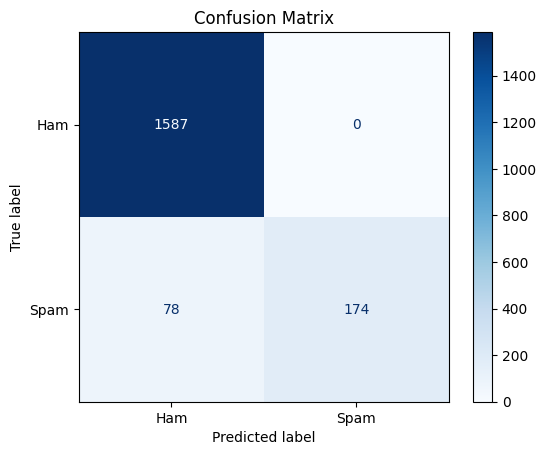

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting the labels for the test set
y_pred = best_model.predict(X_test)

# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()